In [1]:
from IPython.core.display import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Draw inline
%matplotlib inline

# Set figure aesthetics
sns.set_style("white", {'ytick.major.size': 10.0})
sns.set_context("talk", font_scale=1.1)

c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
train_users = pd.read_csv('input/train_users_2.csv')
test_users = pd.read_csv('input/test_users.csv')
piv_train = train_users.shape[0] # Store length of train_users file
labels = train_users['country_destination'].values

all_users = pd.concat([train_users,test_users],axis=0,ignore_index=True) #Combine train and test for joint processing.
all_users_preserved = all_users

In [3]:
session_df = pd.read_csv('input/sessions.csv')
session_users = session_df

# Clean missing values
session_users['secs_elapsed'].fillna(0,inplace=True)
session_users['action_type'].fillna('',inplace=True)

session_df.head(20)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,,NaN,Windows Desktop,319
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753
2,d1mm9tcy42,lookup,,NaN,Windows Desktop,301
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141
4,d1mm9tcy42,lookup,,NaN,Windows Desktop,435
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703
6,d1mm9tcy42,lookup,,NaN,Windows Desktop,115
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842
9,d1mm9tcy42,lookup,,NaN,Windows Desktop,683


In [4]:
## Okay let's try adding all the groupings separately.
session_action = session_users.groupby(['user_id','action']).count()['secs_elapsed'].unstack().fillna(0)
session_action_type = session_users.groupby(['user_id','action_type']).count()['secs_elapsed'].unstack().fillna(0)
#session_action_detail = session_actions = session_users.groupby(['user_id','action_detail']).count()['secs_elapsed'].unstack().fillna(0)

sessions_pure = pd.merge(session_action,session_action_type,left_index=True,right_index=True,how='inner')
#sessions_pure = sessions_pure.merge(session_action_detail,left_index=True,right_index=True,how='inner')

In [5]:
# Create New Combined Feature for Grouping
session_users['action_action_detail'] = session_users['action']+'__'+session_users['action_detail']
session_users2 = session_users.groupby(['user_id','action_action_detail']).count()['secs_elapsed'].unstack().fillna(0)
print('Number of Action Count Features created:', session_users2.shape[1])
print('\n')

# Time spent on each Device
deviceusage_df = session_df[session_df['secs_elapsed']<60*100][['user_id','device_type','secs_elapsed']].groupby(['user_id','device_type']).sum().unstack()['secs_elapsed']
# Number of device types used
deviceusage_df['num_devices'] = session_df.groupby('user_id')['device_type'].agg(lambda x: len(np.unique(x.values)))
deviceusage_df.fillna(0,inplace=True)
deviceusage_df.head(2)

Number of Action Count Features created: 436




device_type,-unknown-,Android App Unknown Phone/Tablet,Android Phone,Blackberry,Chromebook,Linux Desktop,Mac Desktop,Opera Phone,Tablet,Windows Desktop,Windows Phone,iPad Tablet,iPhone,iPodtouch,num_devices
user_id,,,,,,,,,,,,,,,
00023iyk9l,0,0,0,0,0,0,25452,0,0,0,0,0,5089,0,2
0010k6l0om,0,0,0,0,0,0,36884,0,0,0,0,0,0,0,1


In [112]:
## Features about individual sessions (sittings)
in_session_actions = session_df[session_df['secs_elapsed']<100*60].groupby('user_id')
AA = in_session_actions['secs_elapsed'].agg({'total_session_times': np.sum,
                                        'mean_secs_per_action' : np.mean,
                                            'num_actions_insession' : np.size})

## Features related to the number of sessions 
between_session_actions = session_df[session_df['secs_elapsed']>200*60].groupby('user_id')
BB = between_session_actions['secs_elapsed'].agg({'num_sessions': np.size,
                                            'mean_between_sessions' : np.mean,
                                            'max_between_sessions': np.max
                                            })

session_times = pd.merge(AA,BB,how='outer',left_index=True,right_index=True)

#Count number of different days spent on AirBnB. Obtained by looking for number of breaks longer than 18 hours.
session_times['num_days'] = session_df[session_df['secs_elapsed']>18*3600].groupby('user_id').count()['secs_elapsed']
session_times.fillna(0,inplace=True)
session_times['num_sessions'] += 1 # Doesn't really make a difference
session_times['num_days'] += 1 
session_times['all_time'] = session_df.groupby('user_id').sum()['secs_elapsed']

session_times.head(3)

,num_actions_insession,mean_secs_per_action,total_session_times,max_between_sessions,num_sessions,mean_between_sessions,num_days,all_time
user_id,,,,,,,,
00023iyk9l,32,954.406250,30541,567165,8,118202.428571,3,867896
0010k6l0om,48,768.416667,36884,127898,12,46397.636364,4,586543
001wyh0pz8,78,1240.833333,96785,50548,7,22506.333333,1,282965


c:\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  5   7  10  12  15  16  60  62  63  99 102 122 139 147 188 259 263 270
 272 273 278 283 303 308 311 318 336 349 366] are constant.
  UserWarning)
c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


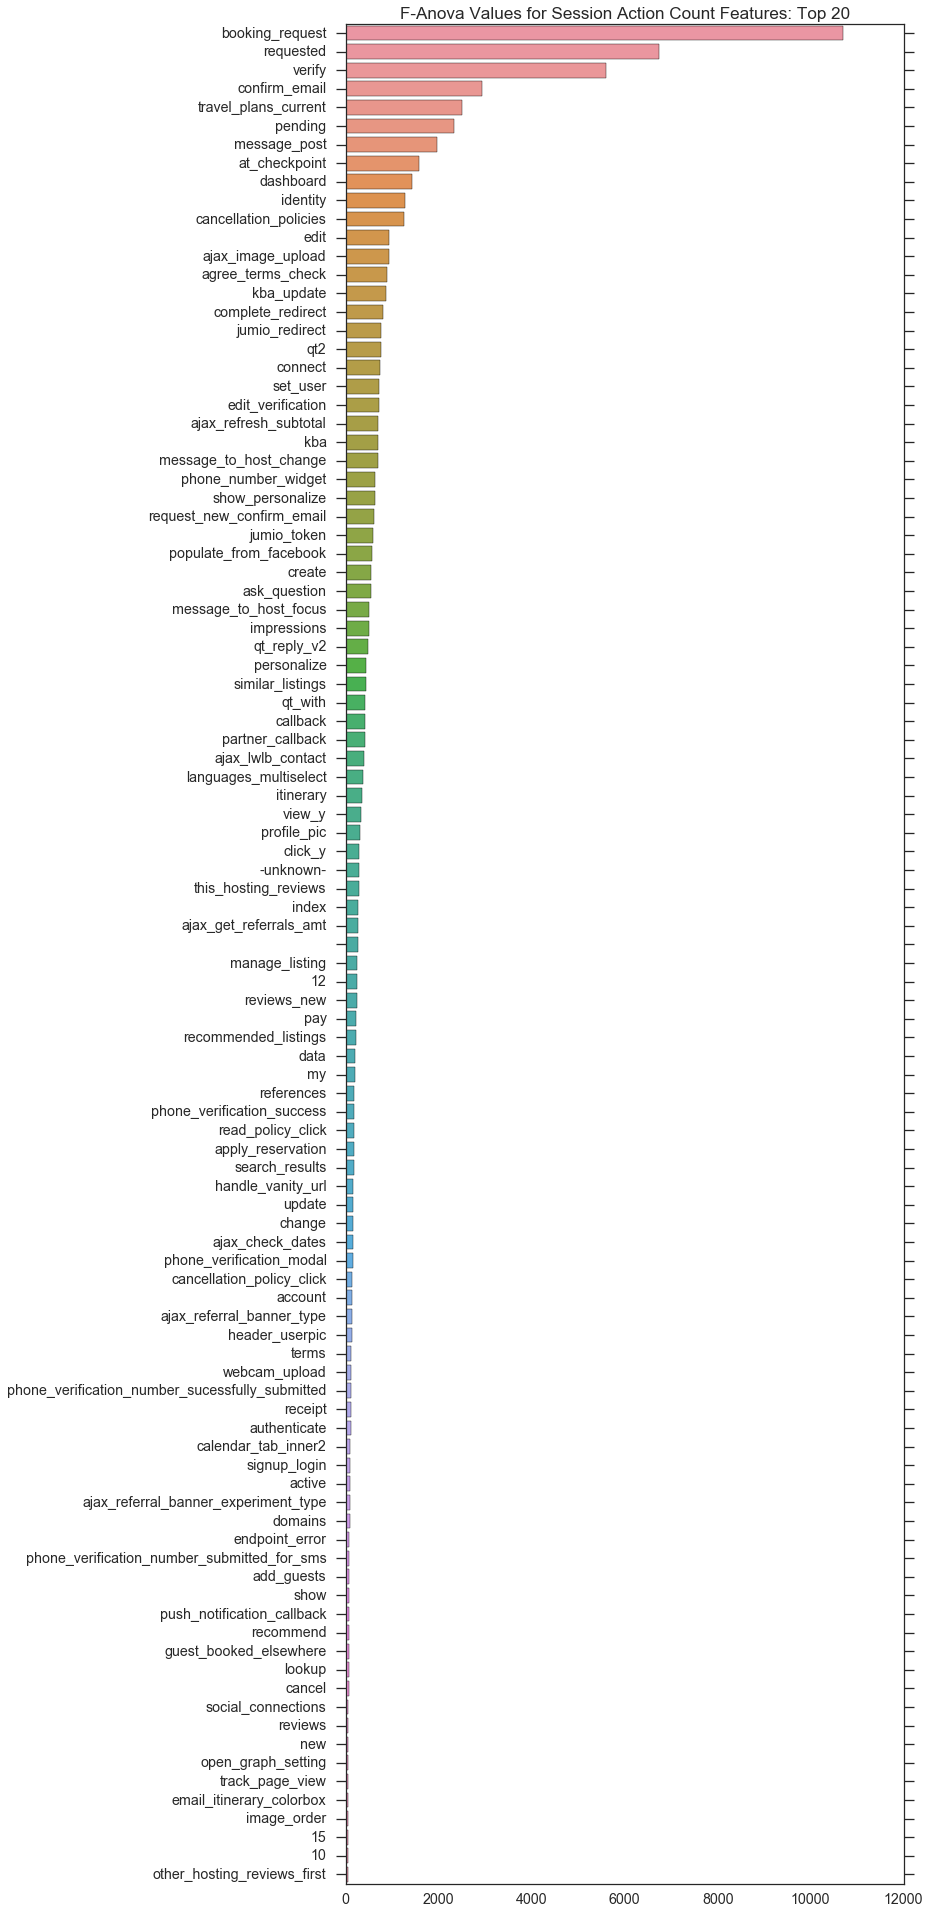

In [7]:
## Need to attach labels for feature selection.
SessionX = pd.merge(train_users[['id','country_destination']],sessions_pure,right_index=True,left_on='id',how='inner')
Sessiony = SessionX['country_destination']!="NDF" # Turn this into a binary classification problem
SessionX.drop(['id','country_destination'],axis=1,inplace=True)


# Perform selection
from sklearn.feature_selection import SelectKBest
selector = SelectKBest(k=300)
selector.fit(SessionX,Sessiony)
sessions_pure = sessions_pure[sessions_pure.columns[selector.get_support()]]

# Examine feature selection univariate statistics test results:
FeaturePvalues = pd.Series(index=SessionX.columns,data=selector.pvalues_).sort_values(ascending=True)
FeatureScores = pd.Series(index=SessionX.columns,data=selector.scores_).sort_values(ascending=False)
# Plot
k = 100
plt.figure(figsize=(10,k/3))
sns.barplot(y=FeatureScores.index[0:k],x=FeatureScores.head(k))
plt.title('F-Anova Values for Session Action Count Features: Top 20')

In [14]:
Sessions = SessionX

In [15]:
Sessions['Booked']=Sessiony

In [16]:
Sessions

,10,11,12,15,about_us,accept_decline,account,acculynk_bin_check_failed,acculynk_bin_check_success,acculynk_load_pin_pad,...,booking_request,booking_response,click_y,data,message_post,modify,partner_callback,submit,view_y,Booked
137021,0,0,0,0,0,0,0,0,0,0,...,0,0,20,35,1,0,0,1,25,True
137022,0,0,0,0,0,0,0,0,0,0,...,0,0,1,3,0,0,0,1,3,False
137023,0,0,0,0,0,0,0,0,0,0,...,1,0,0,2,1,0,0,4,1,False
137024,0,0,0,0,0,0,0,0,0,0,...,0,0,64,39,0,0,0,1,12,False
137025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
137026,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,False
137027,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,2,0,0,2,1,True
137028,0,0,0,0,0,0,0,0,0,0,...,0,0,12,12,0,0,0,1,9,False
137029,0,0,0,0,0,0,0,0,0,0,...,0,0,9,11,3,0,0,3,8,True
137031,0,0,0,0,0,0,0,0,0,0,...,0,0,89,78,11,0,0,11,76,False


c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


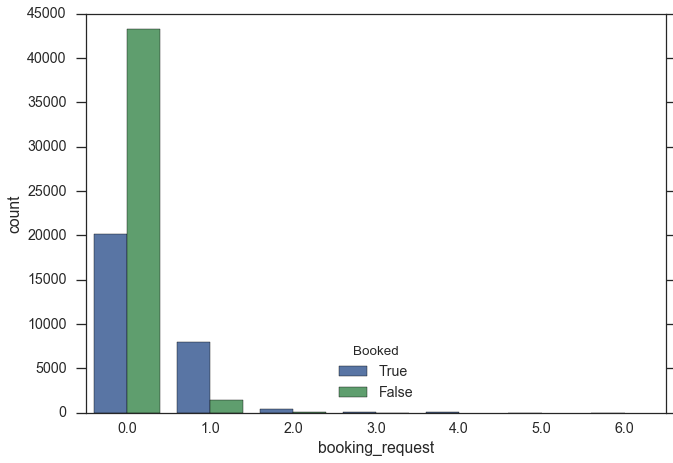

In [29]:
sns.countplot(data=Sessions,hue='Booked',x='booking_request')

In [25]:
# P(Booked|booking request)
sum((Sessions['booking_request']>0)&Sessions['Booked'])/sum(Sessions['booking_request']>0)

0.84634609617114864

In [26]:
# P(Booked|-booking request)
sum((Sessions['booking_request']==0)&Sessions['Booked'])/sum(Sessions['booking_request']==0)

0.31776098922763907

In [37]:
for i in range(0,50):
    I = FeatureScores.index[i]
    temp1 = sum((Sessions[I]>0)&Sessions['Booked'])/sum(Sessions[I]>0)
    print('P(Booked|',I,')=',temp1)
    temp2 = sum((Sessions[I]==0)&Sessions['Booked'])/sum(Sessions[I]==0)
    print('P(Booked|',I,')=',temp2)
    print('Odds Ratio: ',temp1/temp2)
    print('\n')

P(Booked| booking_request )= 0.846346096171
P(Booked| booking_request )= 0.317760989228
Odds Ratio:  2.66346758999


P(Booked| requested )= 0.873342736248
P(Booked| requested )= 0.338093371132
Odds Ratio:  2.5831406671


P(Booked| verify )= 0.685388127854
P(Booked| verify )= 0.325340988285
Odds Ratio:  2.10667623365


P(Booked| confirm_email )= 0.503808171432
P(Booked| confirm_email )= 0.306506364922
Odds Ratio:  1.6437119391


P(Booked| travel_plans_current )= 0.713972286374
P(Booked| travel_plans_current )= 0.346430667532
Odds Ratio:  2.06093845981


P(Booked| pending )= 0.854977010066
P(Booked| pending )= 0.332517327376
Odds Ratio:  2.57122543601


P(Booked| message_post )= 0.57749909124
P(Booked| message_post )= 0.277279065714
Odds Ratio:  2.08273599651


P(Booked| at_checkpoint )= 0.768144370341
P(Booked| at_checkpoint )= 0.376180193912
Odds Ratio:  2.04195856872


P(Booked| dashboard )= 0.498966627139
P(Booked| dashboard )= 0.316374655396
Odds Ratio:  1.57713842948


P(Booked| id

In [32]:
FeatureScores.index[0]

'booking_request'

In [31]:
FeatureScores

booking_request                    10686.460085
requested                           6731.427675
verify                              5589.248392
confirm_email                       2929.098878
travel_plans_current                2498.706251
pending                             2321.624283
message_post                        1966.271468
at_checkpoint                       1579.205606
dashboard                           1416.776942
identity                            1285.840735
cancellation_policies               1254.571169
edit                                 936.168029
ajax_image_upload                    923.077647
agree_terms_check                    889.299316
kba_update                           869.005109
complete_redirect                    804.168280
jumio_redirect                       768.743565
qt2                                  758.231086
connect                              729.086227
set_user                             721.444105
edit_verification                    708

In [228]:
ST = pd.merge(train_users[['id','country_destination']],session_times,right_index=True,left_on='id',how='inner')
ST['Booked'] = ST['country_destination']!='NDF'

In [60]:
Sessions.plot.

['booking_request', 'requested']

In [53]:
ST.head(2)

,id,country_destination,num_actions_insession,mean_secs_per_action,total_session_times,max_between_sessions,num_sessions,mean_between_sessions,num_days,Booked
137021,d1mm9tcy42,other,86,673.081395,57885,606881,34,99832.363636,21,True
137022,yo8nz8bqcq,NDF,5,2022.000000,10110,115983,5,49433.000000,2,False


In [75]:
sns.set_style("whitegrid")


c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


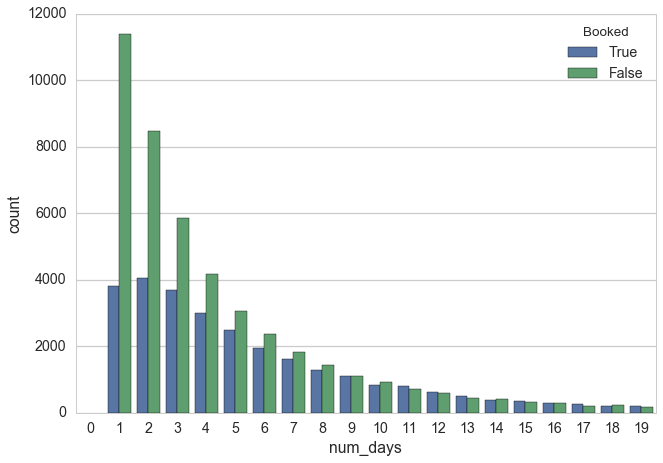

In [98]:
sns.countplot(hue="Booked",x="num_days",data=ST,order=range(0,20))
#plt.ylim([0,20])

c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


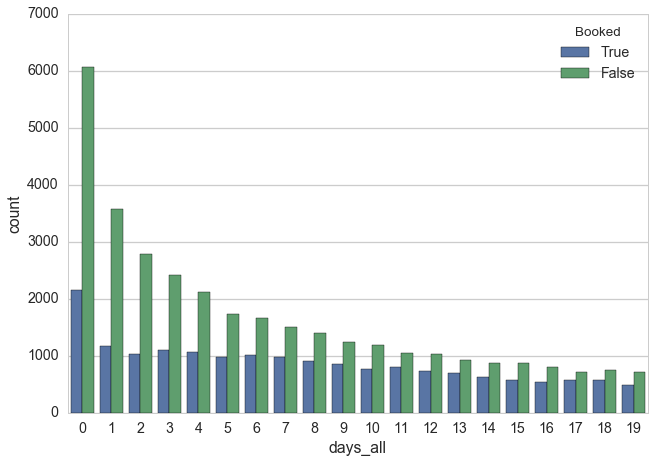

In [120]:
sns.countplot(hue="Booked",x="days_all",data=ST,order=range(0,20))
#plt.ylim([0,20])

In [225]:
np.round(session_times['total_session_times']/(3600))

user_id
00023iyk9l      8
0010k6l0om     10
001wyh0pz8     27
0028jgx1x1      4
002qnbzfs5    183
0031awlkjq      2
0035hobuyj    111
00378ocvlh     19
00389675gq     35
003iamz20l     27
0048rkdgb1      6
0057snrdpu      5
005jc3nbmb      8
005v5uf4dh      4
0063bawn05     12
006ml14zc1      6
006mls2sjw     37
006t3vhawl      5
006z8b0uws      2
0075z9e9xv     65
007gj7kqdk      3
009a40t3dk      8
00a8dbifj8     18
00allnceb8      0
00an0o6c07     26
00b9hfwaak     10
00bn6hu437      9
00bowi9sn3      4
00bqkh0g5i      0
00bxmflswn     30
             ... 
zzq90ckj2z      8
zzqb2sn066      1
zzr1rkdsh9     18
zzrnx9rqi5      5
zzsoxtv8zb     11
zzsslqqkee      3
zzsszlux3t      0
zzswqjsqy4      9
zzt5gpsyqa      9
zzt8w28nl5     32
zztaeo9wd5     16
zztkv1gkse      4
zzu3u71odh     15
zzu6ezwap2      3
zzunwylrfv     55
zzuy4rvdki      2
zzv6z6rjr9     29
zzv8sgicbk      6
zzvatt4dio     85
zzvg4emw5w     22
zzvr84im58      1
zzw7kydxfa      0
zzx06inhbv      0
zzx0hfd74v     17
zz

In [231]:
ST = pd.merge(train_users[['id','country_destination']],session_times,right_index=True,left_on='id',how='inner')
ST['Booked'] = ST['country_destination']!='NDF'
ST

,id,country_destination,num_actions_insession,mean_secs_per_action,total_session_times,max_between_sessions,num_sessions,mean_between_sessions,num_days,all_time,Booked
137021,d1mm9tcy42,other,86,673.081395,57885,606881,34,99832.363636,21,3427529,True
137022,yo8nz8bqcq,NDF,5,2022.000000,10110,115983,5,49433.000000,2,207842,False
137023,4grx6yxeby,NDF,7,1192.428571,8347,336801,10,125233.000000,8,1135444,False
137024,ncf87guaf0,NDF,118,1458.932203,172154,732296,26,140378.400000,16,3755100,False
137025,4rvqpxoh3h,GB,8,319.375000,2555,0,1,0.000000,1,2555,True
137026,c8mfesvkv0,NDF,1,0.000000,0,1371616,2,1371616.000000,2,1380288,False
137027,xwxei6hdk4,US,6,568.500000,3411,46262,2,46262.000000,1,49673,True
137028,5f45ro5uzk,NDF,31,876.967742,27186,117638,12,49258.727273,3,605413,False
137029,ro2stddszp,other,32,689.093750,22051,658848,11,125515.800000,5,1284401,True
137031,qtw88d9pbl,NDF,288,1057.663194,304607,485255,45,52143.772727,6,2868205,False


In [232]:
ST['total_session_times'] = np.round(ST['total_session_times']/(3600))
ST.head(5)

,id,country_destination,num_actions_insession,mean_secs_per_action,total_session_times,max_between_sessions,num_sessions,mean_between_sessions,num_days,all_time,Booked
137021,d1mm9tcy42,other,86,673.081395,16,606881,34,99832.363636,21,3427529,True
137022,yo8nz8bqcq,NDF,5,2022.000000,3,115983,5,49433.000000,2,207842,False
137023,4grx6yxeby,NDF,7,1192.428571,2,336801,10,125233.000000,8,1135444,False
137024,ncf87guaf0,NDF,118,1458.932203,48,732296,26,140378.400000,16,3755100,False
137025,4rvqpxoh3h,GB,8,319.375000,1,0,1,0.000000,1,2555,True


In [240]:
ST

,id,country_destination,num_actions_insession,mean_secs_per_action,total_session_times,max_between_sessions,num_sessions,mean_between_sessions,num_days,all_time,Booked
137021,d1mm9tcy42,other,86,673.081395,16,606881,34,99832.363636,21,3427529,True
137022,yo8nz8bqcq,NDF,5,2022.000000,3,115983,5,49433.000000,2,207842,False
137023,4grx6yxeby,NDF,7,1192.428571,2,336801,10,125233.000000,8,1135444,False
137024,ncf87guaf0,NDF,118,1458.932203,48,732296,26,140378.400000,16,3755100,False
137025,4rvqpxoh3h,GB,8,319.375000,1,0,1,0.000000,1,2555,True
137026,c8mfesvkv0,NDF,1,0.000000,0,1371616,2,1371616.000000,2,1380288,False
137027,xwxei6hdk4,US,6,568.500000,1,46262,2,46262.000000,1,49673,True
137028,5f45ro5uzk,NDF,31,876.967742,8,117638,12,49258.727273,3,605413,False
137029,ro2stddszp,other,32,689.093750,6,658848,11,125515.800000,5,1284401,True
137031,qtw88d9pbl,NDF,288,1057.663194,85,485255,45,52143.772727,6,2868205,False


In [239]:
ST.sort_values(by='total_session_times',ascending=False)

,id,country_destination,num_actions_insession,mean_secs_per_action,total_session_times,max_between_sessions,num_sessions,mean_between_sessions,num_days,all_time,Booked
189630,8ikl7vnfa3,US,1523,1629.055154,689,263883,115,32186.254386,9,6928057,True
144318,vcmr2jh5ix,other,1834,1263.158124,644,632080,143,47681.732394,20,9998254,True
202423,0hjoc5q8nf,US,2502,886.832134,616,1030948,82,56232.098765,14,7291459,True
208606,monrpvx2md,US,2136,896.490169,532,685220,74,55360.342466,13,6423234,True
188861,e8h4qghxlg,NDF,1722,1073.069686,513,264102,105,38139.134615,13,6633362,False
201763,p1183hxzc4,NDF,1805,972.872576,488,127555,75,27382.918919,4,4267581,False
143121,yu5bdalz2b,US,1367,1285.176298,488,1442297,281,100820.082143,92,31393292,True
137320,rzqll1bkyo,NDF,659,2302.268589,421,104159,5,61285.000000,3,2018157,False
141221,pwgji1tuko,other,881,1706.480136,418,362599,205,30447.112745,12,8709536,True
161296,9o8odsj9vl,NDF,902,1616.331486,405,1015946,302,43323.385382,36,15690037,False


In [233]:
STTS = ST.groupby(['total_session_times','Booked']).count()['id'].unstack().fillna(0)
STTS['Proportion'] = STTS[True]/(STTS[True]+STTS[False])
STTS['Total'] = (STTS[True]+STTS[False])
STTS['CumProp'] = STTS[True].cumsum()/STTS[True].sum()

In [203]:
STP.describe()

Booked,False,True,Proportion,Total,CumProp
count,217.000000,217.000000,217.000000,217.000000,217.000000
mean,207.562212,132.599078,0.545396,340.161290,0.900096
std,614.357966,279.760348,0.239228,883.401809,0.189228
min,0.000000,0.000000,0.000000,1.000000,0.074859
25%,1.000000,2.000000,0.453055,4.000000,0.911622
50%,9.000000,12.000000,0.523810,22.000000,0.986655
75%,90.000000,106.000000,0.666667,200.000000,0.997115
max,6064.000000,2154.000000,1.000000,8218.000000,1.000000


In [244]:
ST.describe()

,num_actions_insession,mean_secs_per_action,total_session_times,max_between_sessions,num_sessions,mean_between_sessions,num_days,all_time,Booked
count,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815.000000,73815
mean,53.827298,1004.866192,15.446156,451791.720680,16.719352,105400.932099,5.362989,1514234.958992,0.389812
std,87.424379,510.070403,25.354940,472195.722433,20.577202,137207.477111,5.795760,1913191.475470,0.487711
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,False
25%,9.000000,666.514451,2.000000,85350.000000,4.000000,38851.200000,2.000000,256920.500000,0
50%,25.000000,974.202532,7.000000,265568.000000,10.000000,69098.409091,3.000000,872862.000000,0
75%,63.000000,1305.888758,18.000000,692551.500000,21.000000,122619.630435,7.000000,2043487.500000,1
max,2502.000000,3846.480000,689.000000,1799977.000000,377.000000,1794761.000000,122.000000,38221363.000000,True


(0, 100)

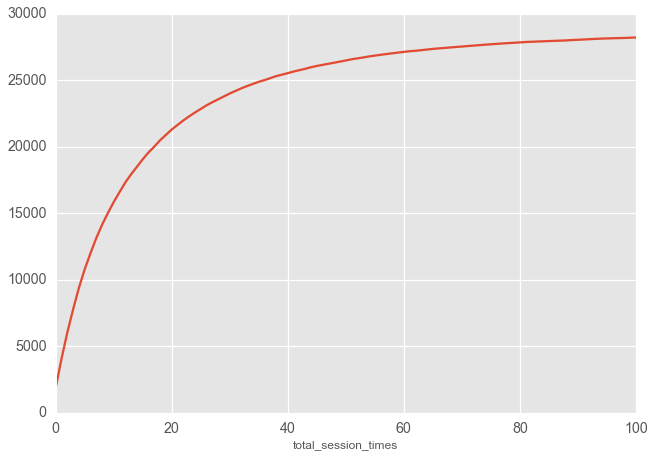

In [236]:
STTS[True].cumsum().plot()
plt.xlim([0,100])

(0, 100)

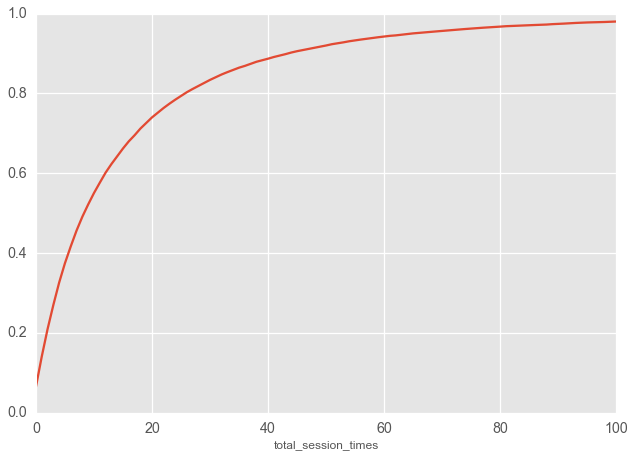

In [237]:
STTS['CumProp'].plot()
plt.xlim([0,100])

(0, 60)

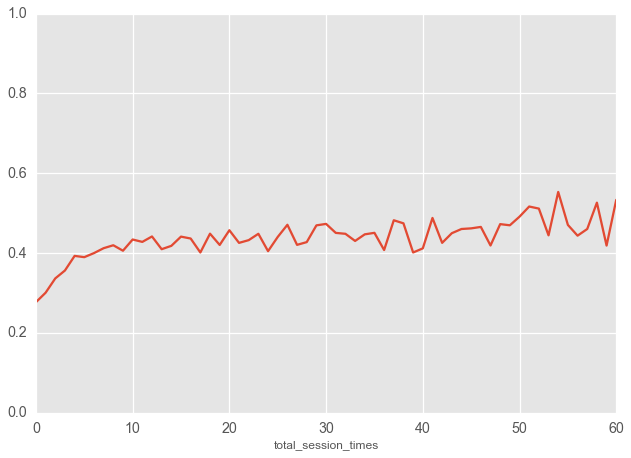

In [245]:
STTS['Proportion'].plot()
plt.xlim([0,60])

(0, 60)

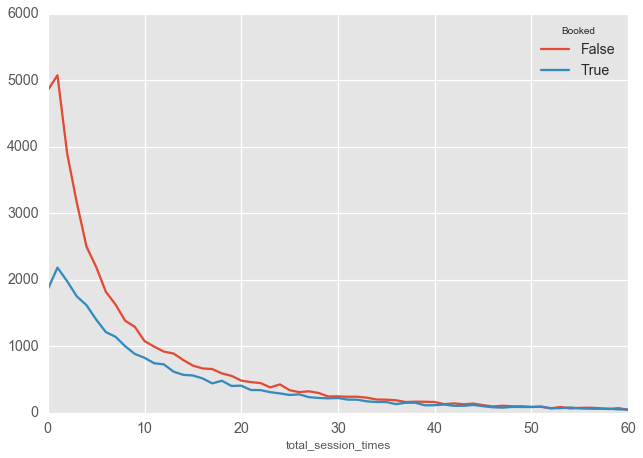

In [247]:
STTS[STTS.columns[0:2]].plot()
plt.xlim([0,60])

## For people we are predicting correctly, how much info do we have?

# What useful things could we do here?
### Identify who the at risk users who have been looking for a long time and otherwise have the profile of someone who would book? Identify pain points . . .

#### By that point we know where they're interested in booking. Might want to ask questions about is it a matter of price? Is it a matter of availability?

#### Find people who are dissatisfied with price in one region and find another . . .

In [152]:
ST['days_all'] = np.round(ST['all_time']/(3600*24))
STP = ST.groupby(['days_all','Booked']).count()['id'].unstack().fillna(0)
STP['Proportion'] = STP[True]/(STP[True]+STP[False])
STP['Total'] = (STP[True]+STP[False])
STP['CumProp'] = STP[True].cumsum()/STP[True].sum()

In [158]:
STTS

In [143]:
import matplotlib
matplotlib.style.use('ggplot')


In [ ]:
STP['days_all'] = np.round(ST['all_time']/(3600*24))
STP = ST.groupby(['days_all','Booked']).count()['id'].unstack().fillna(0)
STP['Proportion'] = STP[True]/(STP[True]+STP[False])
STP['Total'] = (STP[True]+STP[False])
STP['CumProp'] = STP[True].cumsum()/STP[True].sum()

In [165]:
STP[True].sum()

28774.0

In [164]:
STP[True].cumsum().loc[100]

28285.0

(0, 100)

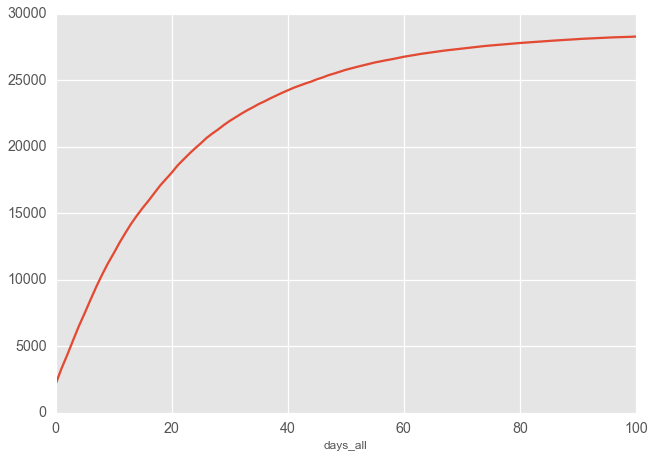

In [166]:
STP[True].cumsum().plot()
plt.xlim([0,100])

(0, 100)

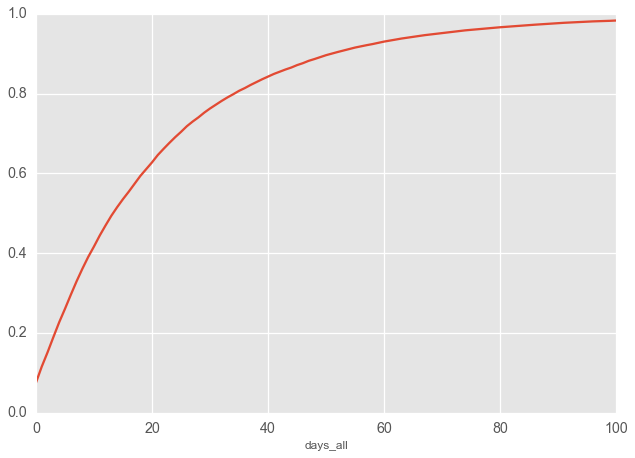

In [159]:
STP['CumProp'].plot()
plt.xlim([0,100])

(0, 60)

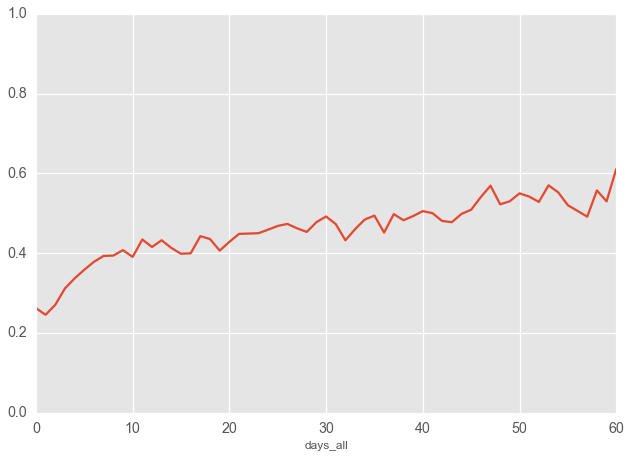

In [167]:
STP['Proportion'].plot()
plt.xlim([0,60])

(0, 30)

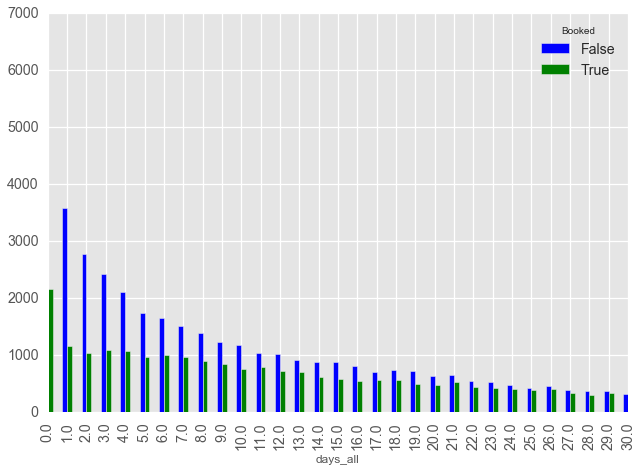

In [170]:
STP[STP.columns[0:2]].plot(kind='bar')
plt.xlim([0,30])

(0, 30)

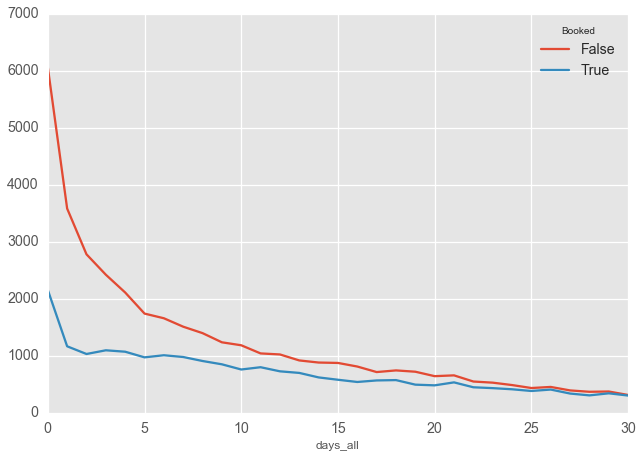

In [171]:
STP[STP.columns[0:2]].plot()
plt.xlim([0,30])

In [ ]:
## Can rerun this on hours of site usage.

In [ ]:
## Data Quality

In [172]:
ST

,id,country_destination,num_actions_insession,mean_secs_per_action,total_session_times,max_between_sessions,num_sessions,mean_between_sessions,num_days,all_time,Booked,days_all
137021,d1mm9tcy42,other,86,673.081395,57885,606881,34,99832.363636,21,3427529,True,40
137022,yo8nz8bqcq,NDF,5,2022.000000,10110,115983,5,49433.000000,2,207842,False,2
137023,4grx6yxeby,NDF,7,1192.428571,8347,336801,10,125233.000000,8,1135444,False,13
137024,ncf87guaf0,NDF,118,1458.932203,172154,732296,26,140378.400000,16,3755100,False,43
137025,4rvqpxoh3h,GB,8,319.375000,2555,0,1,0.000000,1,2555,True,0
137026,c8mfesvkv0,NDF,1,0.000000,0,1371616,2,1371616.000000,2,1380288,False,16
137027,xwxei6hdk4,US,6,568.500000,3411,46262,2,46262.000000,1,49673,True,1
137028,5f45ro5uzk,NDF,31,876.967742,27186,117638,12,49258.727273,3,605413,False,7
137029,ro2stddszp,other,32,689.093750,22051,658848,11,125515.800000,5,1284401,True,15
137031,qtw88d9pbl,NDF,288,1057.663194,304607,485255,45,52143.772727,6,2868205,False,33


c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


(0, 20)

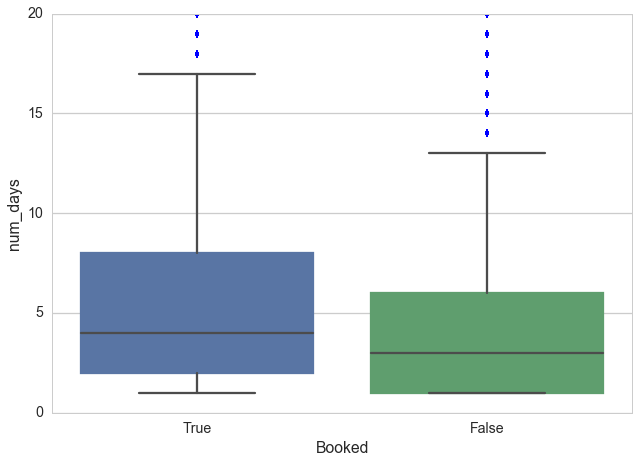

In [78]:
sns.boxplot(x="Booked",y="num_days",data=ST)
plt.ylim([0,20])

Bin according to number of days . . .
Then calculate proportion.

In [119]:
ST

,id,country_destination,num_actions_insession,mean_secs_per_action,total_session_times,max_between_sessions,num_sessions,mean_between_sessions,num_days,all_time,Booked,days_all
137021,d1mm9tcy42,other,86,673.081395,57885,606881,34,99832.363636,21,3427529,True,40
137022,yo8nz8bqcq,NDF,5,2022.000000,10110,115983,5,49433.000000,2,207842,False,2
137023,4grx6yxeby,NDF,7,1192.428571,8347,336801,10,125233.000000,8,1135444,False,13
137024,ncf87guaf0,NDF,118,1458.932203,172154,732296,26,140378.400000,16,3755100,False,43
137025,4rvqpxoh3h,GB,8,319.375000,2555,0,1,0.000000,1,2555,True,0
137026,c8mfesvkv0,NDF,1,0.000000,0,1371616,2,1371616.000000,2,1380288,False,16
137027,xwxei6hdk4,US,6,568.500000,3411,46262,2,46262.000000,1,49673,True,1
137028,5f45ro5uzk,NDF,31,876.967742,27186,117638,12,49258.727273,3,605413,False,7
137029,ro2stddszp,other,32,689.093750,22051,658848,11,125515.800000,5,1284401,True,15
137031,qtw88d9pbl,NDF,288,1057.663194,304607,485255,45,52143.772727,6,2868205,False,33


In [ ]:
ST.groupby(['id',])

In [89]:
ST['num_days'].quantile(.98)

23.0

c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


(0, 23)

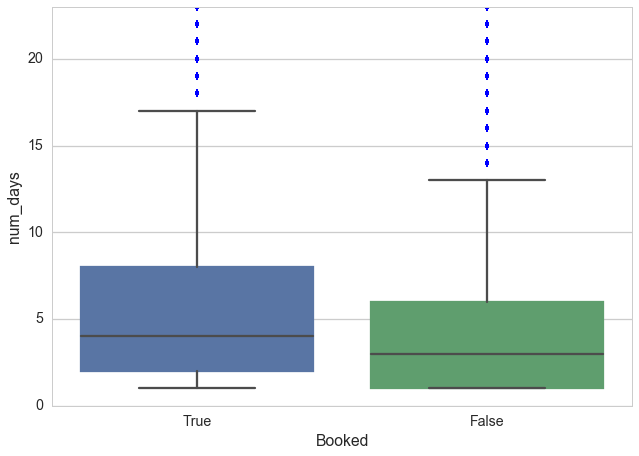

In [90]:
sns.boxplot(x="Booked",y="num_days",data=ST)
plt.ylim([0,23])

c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


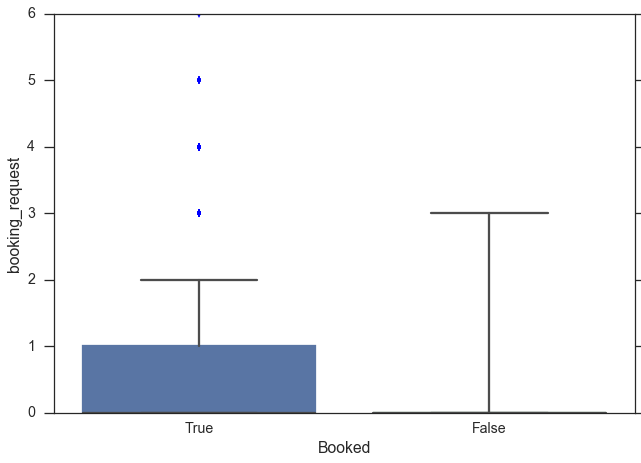

In [56]:
sns.boxplot(x="Booked",y="booking_request",data=Sessions)

In [ ]:

plt.boxplot(x=ST['num_days'],y='Booked')

c:\Anaconda3\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


TypeError: 'NoneType' object is not iterable

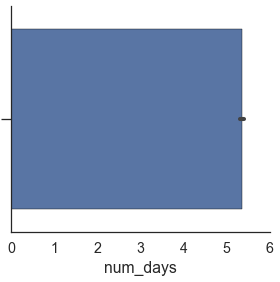

In [50]:
g = sns.factorplot(x='num_days',hue='Booked',data=ST,kind='bar')

In [40]:
ST

,id,country_destination,num_actions_insession,mean_secs_per_action,total_session_times,max_between_sessions,num_sessions,mean_between_sessions,num_days
137021,d1mm9tcy42,other,86,673.081395,57885,606881,34,99832.363636,21
137022,yo8nz8bqcq,NDF,5,2022.000000,10110,115983,5,49433.000000,2
137023,4grx6yxeby,NDF,7,1192.428571,8347,336801,10,125233.000000,8
137024,ncf87guaf0,NDF,118,1458.932203,172154,732296,26,140378.400000,16
137025,4rvqpxoh3h,GB,8,319.375000,2555,0,1,0.000000,1
137026,c8mfesvkv0,NDF,1,0.000000,0,1371616,2,1371616.000000,2
137027,xwxei6hdk4,US,6,568.500000,3411,46262,2,46262.000000,1
137028,5f45ro5uzk,NDF,31,876.967742,27186,117638,12,49258.727273,3
137029,ro2stddszp,other,32,689.093750,22051,658848,11,125515.800000,5
137031,qtw88d9pbl,NDF,288,1057.663194,304607,485255,45,52143.772727,6


In [248]:
sessions_pure

,10,11,12,15,about_us,account,acculynk_bin_check_success,acculynk_load_pin_pad,acculynk_pin_pad_inactive,acculynk_session_obtained,...,wishlists,,-unknown-,booking_request,click_y,data,message_post,partner_callback,submit,view_y
user_id,,,,,,,,,,,,,,,,,,,,,
00023iyk9l,0,0,0,0,0,0,0,0,0,0,...,0,3,0,1,4,9,1,1,0,21
0010k6l0om,0,0,0,0,0,0,0,0,0,0,...,0,15,5,0,16,9,0,1,0,17
001wyh0pz8,0,0,0,0,0,0,0,0,0,0,...,0,5,6,0,66,2,0,0,3,8
0028jgx1x1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,9,5,0,0,1,15
002qnbzfs5,9,0,0,0,0,0,0,0,0,0,...,0,77,184,1,140,140,16,0,15,216
0031awlkjq,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,1,0,0,0,3
0035hobuyj,0,0,0,0,0,0,0,0,0,0,...,0,171,9,0,206,41,3,0,4,55
00378ocvlh,0,0,0,0,0,0,0,0,0,0,...,0,4,20,0,5,4,1,0,5,36
00389675gq,0,0,0,0,0,1,0,0,0,0,...,0,14,23,0,22,34,2,0,8,74
